In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [5]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 100
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  51.32642364501953
Epoch Number :  1
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  50.7
	 Epoch Loss  50.69278335571289
Epoch Number :  2
	 Training accuracy:  49.8
	 Validation accuracy  62.5
	 Test accuracy  50.2
	 Epoch Loss  50.11220169067383
Epoch Number :  3
	 Training accuracy:  50.93333333333333
	 Validation accuracy  62.5
	 Test accuracy  49.4
	 Epoch Loss  49.59444046020508
Epoch Number :  4
	 Training accuracy:  53.96666666666667
	 Validation accuracy  61.875
	 Test accuracy  47.7
	 Epoch Loss  49.473854064941406
Epoch Number :  5
	 Training accuracy:  56.96666666666667
	 Validation accuracy  58.75
	 Test accuracy  46.7
	 Epoch Loss  49.16432189941406
Epoch Number :  6
	 Training accuracy:  59.233333333333334
	 Validation accuracy  53.125
	 Test accuracy  44.0
	 Epoch Loss  49.121150970458984
Epoch Number :  7
	 Training accuracy:

Epoch Number :  60
	 Training accuracy:  88.23333333333333
	 Validation accuracy  85.625
	 Test accuracy  79.4
	 Epoch Loss  30.49911117553711
Epoch Number :  61
	 Training accuracy:  88.06666666666666
	 Validation accuracy  83.125
	 Test accuracy  79.4
	 Epoch Loss  30.07410430908203
Epoch Number :  62
	 Training accuracy:  88.43333333333334
	 Validation accuracy  83.125
	 Test accuracy  76.5
	 Epoch Loss  30.086576461791992
Epoch Number :  63
	 Training accuracy:  88.36666666666666
	 Validation accuracy  83.125
	 Test accuracy  78.8
	 Epoch Loss  28.74829864501953
Epoch Number :  64
	 Training accuracy:  88.13333333333334
	 Validation accuracy  83.125
	 Test accuracy  79.5
	 Epoch Loss  29.35053062438965
Epoch Number :  65
	 Training accuracy:  89.33333333333333
	 Validation accuracy  86.25
	 Test accuracy  78.7
	 Epoch Loss  28.648595809936523
Epoch Number :  66
	 Training accuracy:  89.7
	 Validation accuracy  87.5
	 Test accuracy  78.7
	 Epoch Loss  28.74439811706543
Epoch Number 

Epoch Number :  19
	 Training accuracy:  72.16666666666667
	 Validation accuracy  59.375
	 Test accuracy  66.1
	 Epoch Loss  43.78188705444336
Epoch Number :  20
	 Training accuracy:  75.36666666666666
	 Validation accuracy  61.25
	 Test accuracy  64.6
	 Epoch Loss  42.30418014526367
Epoch Number :  21
	 Training accuracy:  77.53333333333333
	 Validation accuracy  58.75
	 Test accuracy  69.1
	 Epoch Loss  41.15180969238281
Epoch Number :  22
	 Training accuracy:  78.06666666666666
	 Validation accuracy  56.25
	 Test accuracy  74.4
	 Epoch Loss  40.300315856933594
Epoch Number :  23
	 Training accuracy:  80.96666666666667
	 Validation accuracy  62.5
	 Test accuracy  71.1
	 Epoch Loss  39.0837516784668
Epoch Number :  24
	 Training accuracy:  81.46666666666667
	 Validation accuracy  62.5
	 Test accuracy  69.8
	 Epoch Loss  38.03091812133789
Epoch Number :  25
	 Training accuracy:  82.73333333333333
	 Validation accuracy  63.75
	 Test accuracy  71.6
	 Epoch Loss  37.50165939331055
Epoch N

Epoch Number :  78
	 Training accuracy:  93.96666666666667
	 Validation accuracy  66.25
	 Test accuracy  76.7
	 Epoch Loss  22.23523712158203
Epoch Number :  79
	 Training accuracy:  94.23333333333333
	 Validation accuracy  75.0
	 Test accuracy  75.9
	 Epoch Loss  22.255861282348633
Epoch Number :  80
	 Training accuracy:  93.76666666666667
	 Validation accuracy  71.25
	 Test accuracy  77.6
	 Epoch Loss  21.457019805908203
Epoch Number :  81
	 Training accuracy:  93.83333333333333
	 Validation accuracy  71.25
	 Test accuracy  78.5
	 Epoch Loss  21.521608352661133
Epoch Number :  82
	 Training accuracy:  94.93333333333334
	 Validation accuracy  65.625
	 Test accuracy  76.8
	 Epoch Loss  20.952775955200195
Epoch Number :  83
	 Training accuracy:  94.83333333333333
	 Validation accuracy  65.0
	 Test accuracy  77.4
	 Epoch Loss  21.261409759521484
Epoch Number :  84
	 Training accuracy:  94.83333333333333
	 Validation accuracy  66.875
	 Test accuracy  77.2
	 Epoch Loss  20.994062423706055


Epoch Number :  38
	 Training accuracy:  87.56666666666666
	 Validation accuracy  67.5
	 Test accuracy  78.7
	 Epoch Loss  30.984031677246094
Epoch Number :  39
	 Training accuracy:  89.0
	 Validation accuracy  68.75
	 Test accuracy  77.8
	 Epoch Loss  30.82451057434082
Epoch Number :  40
	 Training accuracy:  89.46666666666667
	 Validation accuracy  70.625
	 Test accuracy  77.7
	 Epoch Loss  29.877912521362305
Epoch Number :  41
	 Training accuracy:  89.7
	 Validation accuracy  73.125
	 Test accuracy  77.7
	 Epoch Loss  29.587207794189453
Epoch Number :  42
	 Training accuracy:  88.23333333333333
	 Validation accuracy  68.75
	 Test accuracy  79.1
	 Epoch Loss  29.189268112182617
Epoch Number :  43
	 Training accuracy:  89.86666666666666
	 Validation accuracy  73.125
	 Test accuracy  77.7
	 Epoch Loss  29.5388126373291
Epoch Number :  44
	 Training accuracy:  89.8
	 Validation accuracy  70.625
	 Test accuracy  77.7
	 Epoch Loss  29.40608024597168
Epoch Number :  45
	 Training accuracy:

Epoch Number :  98
	 Training accuracy:  94.6
	 Validation accuracy  75.0
	 Test accuracy  79.7
	 Epoch Loss  20.00348472595215
Epoch Number :  99
	 Training accuracy:  95.03333333333333
	 Validation accuracy  75.0
	 Test accuracy  80.8
	 Epoch Loss  20.375076293945312
Repetition 3
Epoch Number :  0
	 Training accuracy:  51.2
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  50.833404541015625
Epoch Number :  1
	 Training accuracy:  51.43333333333333
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  50.60376739501953
Epoch Number :  2
	 Training accuracy:  51.43333333333333
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  50.43458938598633
Epoch Number :  3
	 Training accuracy:  51.8
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  50.365814208984375
Epoch Number :  4
	 Training accuracy:  51.833333333333336
	 Validation accuracy  37.5
	 Test accuracy  48.7
	 Epoch Loss  50.22038650512695
Epoch Number :  5
	 Training accuracy:  

Epoch Number :  58
	 Training accuracy:  87.83333333333333
	 Validation accuracy  79.375
	 Test accuracy  78.2
	 Epoch Loss  30.60795021057129
Epoch Number :  59
	 Training accuracy:  87.53333333333333
	 Validation accuracy  79.375
	 Test accuracy  78.7
	 Epoch Loss  30.801673889160156
Epoch Number :  60
	 Training accuracy:  88.06666666666666
	 Validation accuracy  77.5
	 Test accuracy  79.3
	 Epoch Loss  30.254228591918945
Epoch Number :  61
	 Training accuracy:  88.13333333333334
	 Validation accuracy  80.625
	 Test accuracy  79.5
	 Epoch Loss  31.03067398071289
Epoch Number :  62
	 Training accuracy:  88.7
	 Validation accuracy  76.875
	 Test accuracy  80.0
	 Epoch Loss  29.61857795715332
Epoch Number :  63
	 Training accuracy:  87.43333333333334
	 Validation accuracy  80.625
	 Test accuracy  80.5
	 Epoch Loss  29.636049270629883
Epoch Number :  64
	 Training accuracy:  88.66666666666667
	 Validation accuracy  78.75
	 Test accuracy  80.4
	 Epoch Loss  29.54228973388672
Epoch Number

Epoch Number :  18
	 Training accuracy:  64.46666666666667
	 Validation accuracy  38.75
	 Test accuracy  42.8
	 Epoch Loss  48.72747802734375
Epoch Number :  19
	 Training accuracy:  64.96666666666667
	 Validation accuracy  40.625
	 Test accuracy  44.4
	 Epoch Loss  48.88908386230469
Epoch Number :  20
	 Training accuracy:  67.33333333333333
	 Validation accuracy  43.125
	 Test accuracy  44.8
	 Epoch Loss  48.55586624145508
Epoch Number :  21
	 Training accuracy:  67.9
	 Validation accuracy  41.25
	 Test accuracy  47.7
	 Epoch Loss  48.12871551513672
Epoch Number :  22
	 Training accuracy:  68.23333333333333
	 Validation accuracy  41.875
	 Test accuracy  47.8
	 Epoch Loss  47.818328857421875
Epoch Number :  23
	 Training accuracy:  69.4
	 Validation accuracy  43.75
	 Test accuracy  48.8
	 Epoch Loss  47.500457763671875
Epoch Number :  24
	 Training accuracy:  69.5
	 Validation accuracy  47.5
	 Test accuracy  54.0
	 Epoch Loss  46.89250564575195
Epoch Number :  25
	 Training accuracy:  

Epoch Number :  78
	 Training accuracy:  90.66666666666667
	 Validation accuracy  74.375
	 Test accuracy  81.1
	 Epoch Loss  29.29840087890625
Epoch Number :  79
	 Training accuracy:  92.36666666666666
	 Validation accuracy  80.625
	 Test accuracy  81.3
	 Epoch Loss  28.962055206298828
Epoch Number :  80
	 Training accuracy:  91.86666666666666
	 Validation accuracy  82.5
	 Test accuracy  80.3
	 Epoch Loss  29.18400764465332
Epoch Number :  81
	 Training accuracy:  92.33333333333333
	 Validation accuracy  76.875
	 Test accuracy  80.8
	 Epoch Loss  27.969736099243164
Epoch Number :  82
	 Training accuracy:  92.43333333333334
	 Validation accuracy  82.5
	 Test accuracy  81.4
	 Epoch Loss  28.279067993164062
Epoch Number :  83
	 Training accuracy:  91.56666666666666
	 Validation accuracy  76.875
	 Test accuracy  81.6
	 Epoch Loss  28.515520095825195
Epoch Number :  84
	 Training accuracy:  90.33333333333333
	 Validation accuracy  74.375
	 Test accuracy  81.8
	 Epoch Loss  28.04645156860351

Epoch Number :  37
	 Training accuracy:  75.03333333333333
	 Validation accuracy  53.125
	 Test accuracy  70.2
	 Epoch Loss  44.10774612426758
Epoch Number :  38
	 Training accuracy:  76.26666666666667
	 Validation accuracy  53.75
	 Test accuracy  68.8
	 Epoch Loss  43.991085052490234
Epoch Number :  39
	 Training accuracy:  76.16666666666667
	 Validation accuracy  43.75
	 Test accuracy  71.5
	 Epoch Loss  43.59620666503906
Epoch Number :  40
	 Training accuracy:  77.4
	 Validation accuracy  58.75
	 Test accuracy  70.9
	 Epoch Loss  43.08738708496094
Epoch Number :  41
	 Training accuracy:  75.9
	 Validation accuracy  51.25
	 Test accuracy  71.8
	 Epoch Loss  42.85292053222656
Epoch Number :  42
	 Training accuracy:  77.16666666666667
	 Validation accuracy  43.75
	 Test accuracy  73.7
	 Epoch Loss  42.4183464050293
Epoch Number :  43
	 Training accuracy:  76.73333333333333
	 Validation accuracy  46.25
	 Test accuracy  74.5
	 Epoch Loss  41.64497756958008
Epoch Number :  44
	 Training a

Epoch Number :  96
	 Training accuracy:  90.4
	 Validation accuracy  84.375
	 Test accuracy  80.0
	 Epoch Loss  24.833843231201172
Epoch Number :  97
	 Training accuracy:  91.33333333333333
	 Validation accuracy  82.5
	 Test accuracy  79.4
	 Epoch Loss  24.1204776763916
Epoch Number :  98
	 Training accuracy:  90.56666666666666
	 Validation accuracy  84.375
	 Test accuracy  80.2
	 Epoch Loss  24.060705184936523
Epoch Number :  99
	 Training accuracy:  91.23333333333333
	 Validation accuracy  82.5
	 Test accuracy  79.1
	 Epoch Loss  23.688396453857422
Repetition 6
Epoch Number :  0
	 Training accuracy:  51.2
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  51.406227111816406
Epoch Number :  1
	 Training accuracy:  51.266666666666666
	 Validation accuracy  37.5
	 Test accuracy  48.8
	 Epoch Loss  51.1050910949707
Epoch Number :  2
	 Training accuracy:  51.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  48.4
	 Epoch Loss  50.805416107177734
Epoch Number :  3
	 

Epoch Number :  56
	 Training accuracy:  85.0
	 Validation accuracy  61.25
	 Test accuracy  71.3
	 Epoch Loss  37.064186096191406
Epoch Number :  57
	 Training accuracy:  85.5
	 Validation accuracy  60.625
	 Test accuracy  71.2
	 Epoch Loss  35.744781494140625
Epoch Number :  58
	 Training accuracy:  85.6
	 Validation accuracy  70.0
	 Test accuracy  68.8
	 Epoch Loss  35.898014068603516
Epoch Number :  59
	 Training accuracy:  86.73333333333333
	 Validation accuracy  65.625
	 Test accuracy  70.4
	 Epoch Loss  36.133094787597656
Epoch Number :  60
	 Training accuracy:  87.23333333333333
	 Validation accuracy  63.125
	 Test accuracy  71.2
	 Epoch Loss  35.41154098510742
Epoch Number :  61
	 Training accuracy:  87.03333333333333
	 Validation accuracy  63.75
	 Test accuracy  71.7
	 Epoch Loss  35.332130432128906
Epoch Number :  62
	 Training accuracy:  87.33333333333333
	 Validation accuracy  69.375
	 Test accuracy  70.7
	 Epoch Loss  34.41866683959961
Epoch Number :  63
	 Training accurac

Epoch Number :  17
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.1
	 Epoch Loss  49.2194709777832
Epoch Number :  18
	 Training accuracy:  51.06666666666667
	 Validation accuracy  37.5
	 Test accuracy  49.2
	 Epoch Loss  49.11476135253906
Epoch Number :  19
	 Training accuracy:  51.13333333333333
	 Validation accuracy  37.5
	 Test accuracy  49.4
	 Epoch Loss  48.83892822265625
Epoch Number :  20
	 Training accuracy:  51.36666666666667
	 Validation accuracy  37.5
	 Test accuracy  49.6
	 Epoch Loss  49.058570861816406
Epoch Number :  21
	 Training accuracy:  51.5
	 Validation accuracy  37.5
	 Test accuracy  49.8
	 Epoch Loss  48.74776077270508
Epoch Number :  22
	 Training accuracy:  51.63333333333333
	 Validation accuracy  37.5
	 Test accuracy  49.8
	 Epoch Loss  48.62252426147461
Epoch Number :  23
	 Training accuracy:  51.766666666666666
	 Validation accuracy  36.875
	 Test accuracy  49.4
	 Epoch Loss  48.31580352783203
Epoch Number :  24
	 Training accura

Epoch Number :  77
	 Training accuracy:  91.36666666666666
	 Validation accuracy  78.75
	 Test accuracy  75.3
	 Epoch Loss  30.32708740234375
Epoch Number :  78
	 Training accuracy:  91.33333333333333
	 Validation accuracy  76.25
	 Test accuracy  70.4
	 Epoch Loss  30.1414852142334
Epoch Number :  79
	 Training accuracy:  91.96666666666667
	 Validation accuracy  76.25
	 Test accuracy  75.3
	 Epoch Loss  29.648387908935547
Epoch Number :  80
	 Training accuracy:  92.3
	 Validation accuracy  77.5
	 Test accuracy  72.0
	 Epoch Loss  29.330625534057617
Epoch Number :  81
	 Training accuracy:  91.93333333333334
	 Validation accuracy  78.75
	 Test accuracy  75.0
	 Epoch Loss  28.742080688476562
Epoch Number :  82
	 Training accuracy:  91.86666666666666
	 Validation accuracy  75.0
	 Test accuracy  75.6
	 Epoch Loss  28.730310440063477
Epoch Number :  83
	 Training accuracy:  92.6
	 Validation accuracy  80.0
	 Test accuracy  73.3
	 Epoch Loss  28.368852615356445
Epoch Number :  84
	 Training a

Epoch Number :  37
	 Training accuracy:  75.33333333333333
	 Validation accuracy  56.25
	 Test accuracy  53.4
	 Epoch Loss  46.338802337646484
Epoch Number :  38
	 Training accuracy:  75.5
	 Validation accuracy  56.875
	 Test accuracy  54.5
	 Epoch Loss  45.7988166809082
Epoch Number :  39
	 Training accuracy:  76.73333333333333
	 Validation accuracy  60.625
	 Test accuracy  54.6
	 Epoch Loss  45.50513458251953
Epoch Number :  40
	 Training accuracy:  77.4
	 Validation accuracy  61.25
	 Test accuracy  57.1
	 Epoch Loss  45.20146179199219
Epoch Number :  41
	 Training accuracy:  77.53333333333333
	 Validation accuracy  61.25
	 Test accuracy  60.6
	 Epoch Loss  45.070430755615234
Epoch Number :  42
	 Training accuracy:  78.63333333333334
	 Validation accuracy  70.0
	 Test accuracy  62.2
	 Epoch Loss  44.97244644165039
Epoch Number :  43
	 Training accuracy:  77.86666666666666
	 Validation accuracy  66.25
	 Test accuracy  62.8
	 Epoch Loss  44.151153564453125
Epoch Number :  44
	 Training

Epoch Number :  96
	 Training accuracy:  92.46666666666667
	 Validation accuracy  83.125
	 Test accuracy  76.9
	 Epoch Loss  26.180221557617188
Epoch Number :  97
	 Training accuracy:  93.66666666666667
	 Validation accuracy  85.625
	 Test accuracy  76.9
	 Epoch Loss  24.822086334228516
Epoch Number :  98
	 Training accuracy:  93.8
	 Validation accuracy  88.125
	 Test accuracy  78.2
	 Epoch Loss  25.484725952148438
Epoch Number :  99
	 Training accuracy:  93.36666666666666
	 Validation accuracy  84.375
	 Test accuracy  76.9
	 Epoch Loss  25.09319496154785
Repetition 9
Epoch Number :  0
	 Training accuracy:  51.56666666666667
	 Validation accuracy  61.875
	 Test accuracy  51.8
	 Epoch Loss  50.3426399230957
Epoch Number :  1
	 Training accuracy:  52.36666666666667
	 Validation accuracy  60.0
	 Test accuracy  51.1
	 Epoch Loss  50.006717681884766
Epoch Number :  2
	 Training accuracy:  53.7
	 Validation accuracy  56.25
	 Test accuracy  50.8
	 Epoch Loss  49.81501007080078
Epoch Number : 

Epoch Number :  56
	 Training accuracy:  87.53333333333333
	 Validation accuracy  55.625
	 Test accuracy  74.0
	 Epoch Loss  30.09437370300293
Epoch Number :  57
	 Training accuracy:  88.03333333333333
	 Validation accuracy  59.375
	 Test accuracy  78.0
	 Epoch Loss  30.46463966369629
Epoch Number :  58
	 Training accuracy:  88.8
	 Validation accuracy  51.875
	 Test accuracy  77.6
	 Epoch Loss  30.12235450744629
Epoch Number :  59
	 Training accuracy:  86.8
	 Validation accuracy  56.25
	 Test accuracy  79.9
	 Epoch Loss  29.36165428161621
Epoch Number :  60
	 Training accuracy:  86.73333333333333
	 Validation accuracy  56.25
	 Test accuracy  78.0
	 Epoch Loss  29.18490219116211
Epoch Number :  61
	 Training accuracy:  88.4
	 Validation accuracy  55.625
	 Test accuracy  77.2
	 Epoch Loss  28.910463333129883
Epoch Number :  62
	 Training accuracy:  89.4
	 Validation accuracy  55.0
	 Test accuracy  74.7
	 Epoch Loss  28.207189559936523
Epoch Number :  63
	 Training accuracy:  89.633333333

torch.Size([10, 100])
0


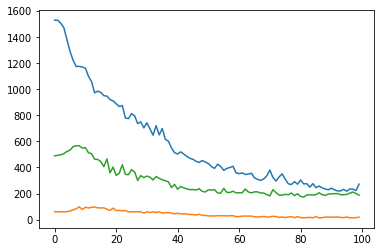

1


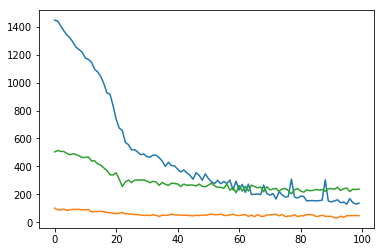

2


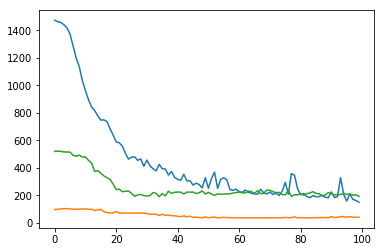

3


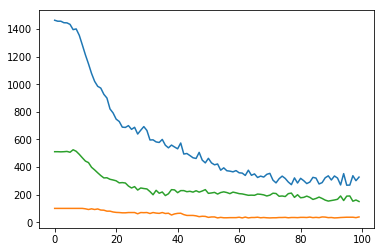

4


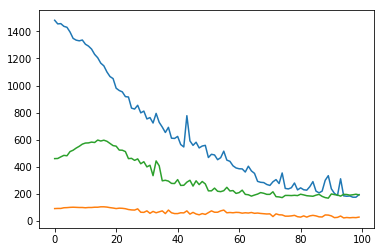

5


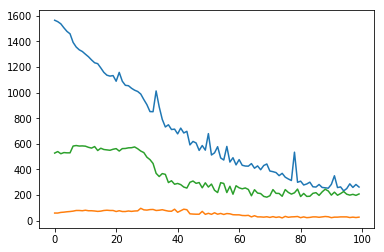

6


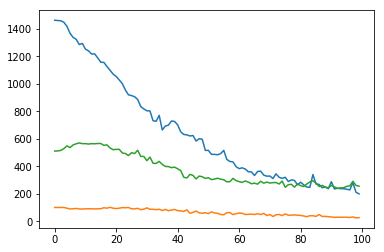

7


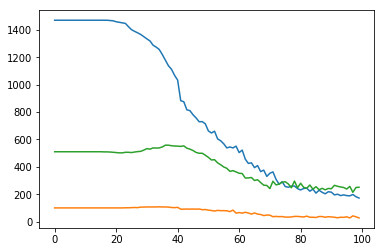

8


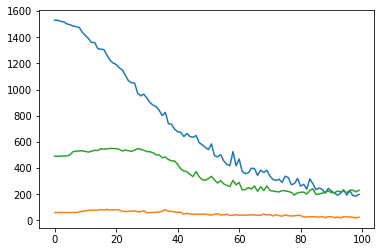

9


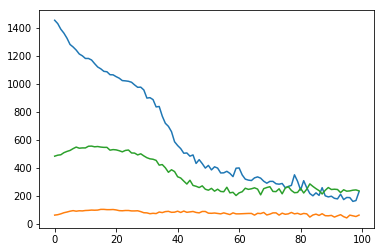

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


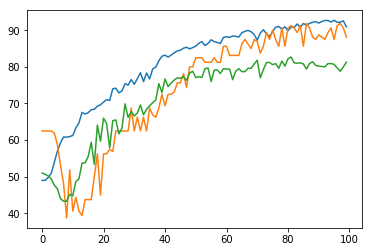

1


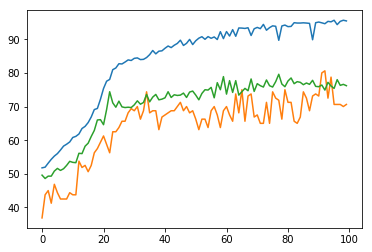

2


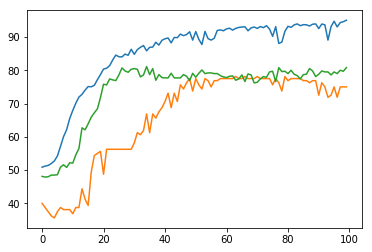

3


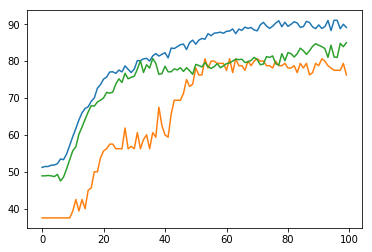

4


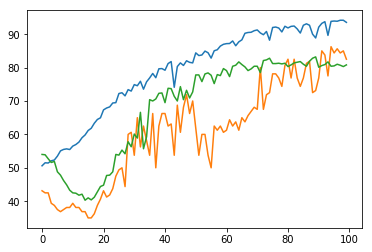

5


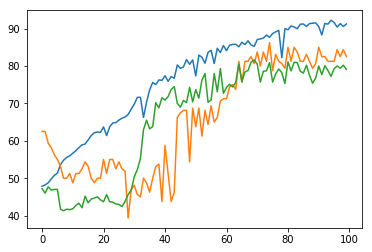

6


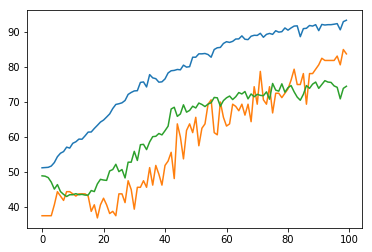

7


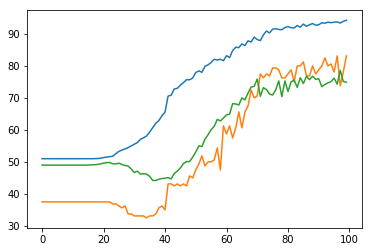

8


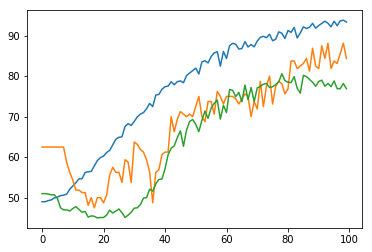

9


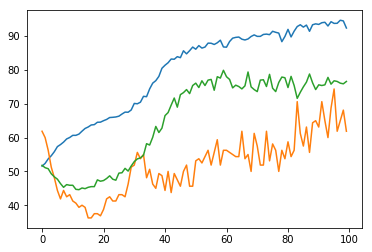

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(100,)
Training accuracy 92.9%+-1.8753645420074463
Validation accuracy 78.8%+-7.50234317779541
Testing accuracy 78.6%+-3.1832222938537598


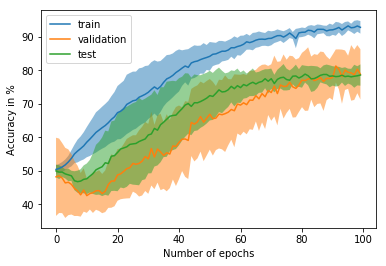

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(100))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))